# Project Name: Real Estate Price Prediction Project

## Feature Engineering

### Common Library Call

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

### Dataset Call 

In [2]:
data=pd.read_csv("data_for_feat_engg.csv")
data.head()

,location,total_sqft,bath,balcony,price,bhk
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4
2,Uttarahalli,1440.0,2.0,3.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3
4,Kothanur,1200.0,2.0,1.0,51.00,2


### Handling the Location feature

In [3]:
# let's see how many unique locations are there

print(f"Unique Locations : {data['location'].nunique()}")

Unique Locations : 1298


In [4]:
# there are too many unique locations!!!
# let's see how much  records are there under each Locations

location_stats=data.groupby("location")["location"].agg("count").sort_values(ascending=False)
location_stats

location
Whitefield             537
Sarjapur  Road         397
Electronic City        302
Kanakpura Road         271
Thanisandra            233
                      ... 
 Banaswadi               1
Kanakadasa Layout        1
Kanakapur main road      1
Kanakapura  Rod          1
whitefiled               1
Name: location, Length: 1298, dtype: int64

In [5]:
# there are several locations that have only one records
# let's see how many locations are there in that has less than 10 records

location_stats_with_rare_record=location_stats[location_stats<=10]
location_stats_with_rare_record

location
Dairy Circle            10
Sadashiva Nagar         10
Nagappa Reddy Layout    10
Kalkere                 10
Naganathapura           10
                        ..
 Banaswadi               1
Kanakadasa Layout        1
Kanakapur main road      1
Kanakapura  Rod          1
whitefiled               1
Name: location, Length: 1058, dtype: int64

In [6]:
# since there are a very large number of individual locations we are not gonna encode it, that will create difficulties
# instead we will pool in those Locations that has only less than ten records into a category named "others"
df1=data.copy()
df1["location"]=df1["location"].apply(lambda x: "others" if x in location_stats_with_rare_record.index else x)
df1["location"]

0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
                   ...           
13252                  Whitefield
13253                      others
13254       Raja Rajeshwari Nagar
13255             Padmanabhanagar
13256                Doddathoguru
Name: location, Length: 13257, dtype: object

In [7]:
# checking the number Of Unique locations after transform
df1.groupby("location")["location"].agg("count")

location
 Devarachikkanahalli           14
1st Block Jayanagar            14
1st Phase JP Nagar             24
2nd Phase Judicial Layout      11
2nd Stage Nagarbhavi           24
                             ... 
Yelahanka                     212
Yelahanka New Town             40
Yelenahalli                    13
Yeshwanthpur                   85
others                       2888
Name: location, Length: 241, dtype: int64

### Creating the the price_per_sqft column

In [8]:
# we will create a column naming price_per_sqft
df1["price_per_sqft"]=df1["price"]*100000/df1["total_sqft"] # as the Price is given in lakh Rs.
df1.head()

,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


### Handling Outliers

In [11]:
# here it is unusual to have less than 300 sqft per bedroom in a house so we remove that kind of record from the data
# let's find out those houses that has less than 300 sqft per bedroom
df1[(df1["total_sqft"]/df1["bhk"])<300].head()

,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
9,others,1020.0,6.0,2.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,2.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,1.0,150.0,6,10660.980810
68,others,1350.0,7.0,0.0,85.0,8,6296.296296
70,others,500.0,3.0,2.0,100.0,3,20000.000000


In [12]:
# let's remove those observations from the dataset 
df2=df1[~((df1["total_sqft"]/df1["bhk"])<300)]
df2.head()

,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


In [13]:
# checking the shape of the data after the removal
df2.shape

(12513, 7)

In [16]:
# remove the ouliers over the Value price per sqft Over different locations
def remove_ppsf_outlier(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby("location"):
        m=np.mean(subdf["price_per_sqft"])
        std=np.std(subdf["price_per_sqft"])
        reduced_df=subdf[(subdf["price_per_sqft"]>m-std) & (subdf["price_per_sqft"]<m+std)]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [17]:
df3=remove_ppsf_outlier(df2)

In [18]:
df3.shape

(10290, 7)

In [58]:
# checking and plotting the house price over location for 2 and 3 bhk
def plot_scatter_bhk(df,location):
    data=df[df["location"]==location]
    df_2bhk=data[data["bhk"]==2]
    df_3bhk=data[data["bhk"]==3]
    plt.rcParams["figure.figsize"]=(10,6)
    plt.scatter(df_2bhk["total_sqft"],df_2bhk["price"],color="blue",marker="o",label="2 BHK")
    plt.scatter(df_3bhk["total_sqft"],df_3bhk["price"],color="green",marker="+",label="3 BHK")
    plt.title(location)
    plt.xlabel("total area")
    plt.ylabel("price")
    plt.legend()

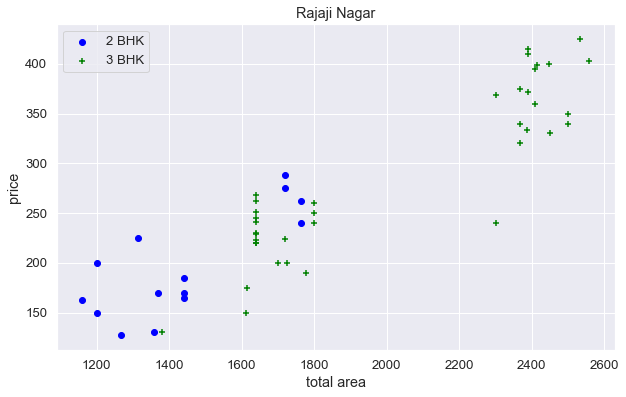

In [59]:
plot_scatter_bhk(df3,"Rajaji Nagar")

In [ ]:
# observe that under same sqft there are several 3 bhk flats that are actually cheaper than 2 bhk flats

In [30]:
# now we will remove the bhk outliers 
# we have observed that even having a more or Less same sqft some 3 bhk house has less prices than that of 2 bhk Houses
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats={}
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk]={
                "mean":np.mean(bhk_df.price_per_sqft),
                "std":np.std(bhk_df.price_per_sqft),
                "count":bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats=bhk_stats.get(bhk-1)
            if stats and stats["count"]>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df["price_per_sqft"]<stats["mean"]].index.values)
    return df.drop(exclude_indices,axis="index")

In [31]:
df4=remove_bhk_outliers(df3)
df4.shape

(7354, 7)

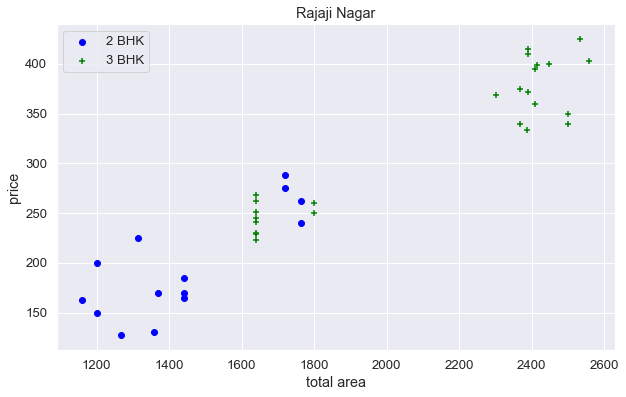

In [60]:
plot_scatter_bhk(df4,"Rajaji Nagar")

In [ ]:
# the abnormality of 3 bhk flats being cheaper than 2 bhk flats is removed

Text(0.5, 1.0, 'distribution of price per sqft')

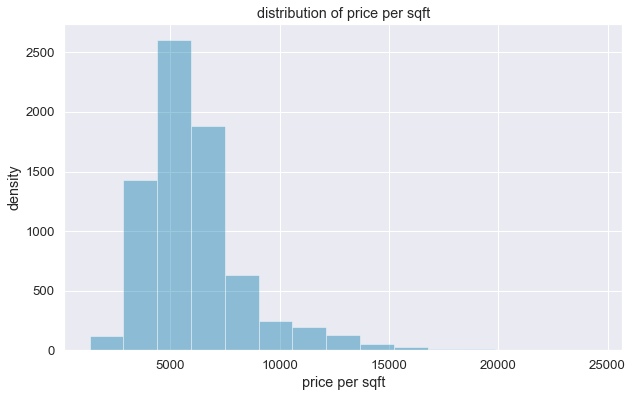

In [74]:
# now we will draw a histogram of the price per sqft distribution
sns.set(rc={"figure.figsize":(10,6)},font_scale=1.2)
sns.distplot(df4["price_per_sqft"],bins=15,kde=False,color="#0078AA")
plt.xlabel("price per sqft")
plt.ylabel("density")
plt.title("distribution of price per sqft")

In [63]:
# the distribution of the distribution of price per sqft looks pretty good as in normal distribution and needs no Transform

Text(0, 0.5, 'count')

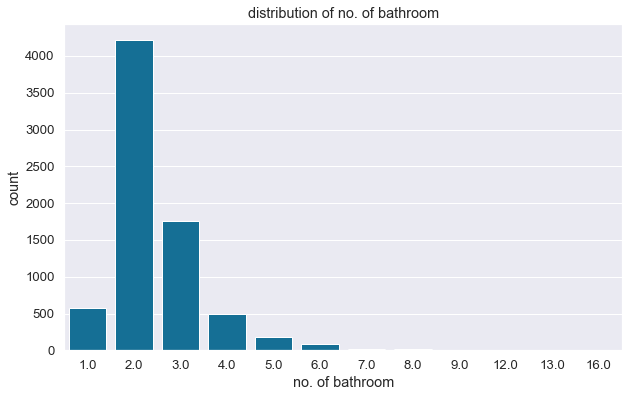

In [72]:
# now let's see how the bathrooms are distributed
sns.set(rc={"figure.figsize":(10,6)},font_scale=1.2)
sns.barplot(df4.groupby("bath")["bath"].count().index.values,
            df4.groupby("bath")["bath"].count(),color="#0078AA")
plt.title("distribution of no. of bathroom")
plt.xlabel("no. of bathroom")
plt.ylabel("count")

In [73]:
# from the domain knowledge we know that a record with bathroom > bhk+2 can be taken as outliers
df5=df4[df4["bath"]<df4["bhk"]+2]
df5.shape

(7276, 7)

In [75]:
# now that we have already used the price_per_sqft and we have no use of it after now so we can drop this column
df6=df5.drop("price_per_sqft",axis=1)
df6.head()

,location,total_sqft,bath,balcony,price,bhk
1,Devarachikkanahalli,1250.0,2.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,2.0,43.0,2


In [77]:
df6.to_csv("data_for_model_sel.csv",index=False)